# AGH Modelling of Physical Systems Lab 3 (2025 March 18th)
Jakub Kubicki  (jakubkubicki@student.agh.edu.pl)

**1. advection PDE**

Let's introduce a few symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   
* ${\color{brown}u}$: carrier velocity field (e.g., wind)   

Transport of $\color{green}\psi$ due to advection by $\color{brown}u$ can be modelled with the advection equation:
$$ \partial_{\color{red} t} {\color{green}\psi} + \partial_{\color{blue}x} \left({\color{brown}u} {\color{green}\psi}\right) = 0 $$

For the special case of $\partial_{\color{blue}x} {\color{brown}u}=0$, an analytical solution describing translation of the signal is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=\psi_0({\color{blue}x} - {\color{brown}u}{\color{red}t})$$
where $\psi_0({\color{blue}x})={\color{green}\psi}({\color{blue}x}, 0)$.

Let's depict the problem using NumPy and matplotlib:

In [12]:
import numpy as np
from matplotlib import pyplot

In [13]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

In [14]:
psi_0 = Psi_0()
nx = 64 #sampling of the curve
x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
u = 2
t_max = 50

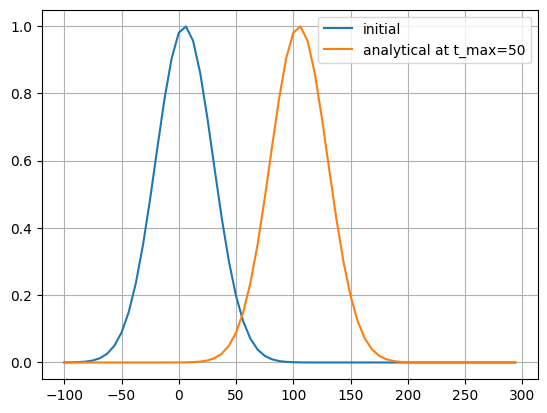

In [15]:
pyplot.plot(x, psi_0(x), label='initial')
pyplot.plot(x, psi_0(x - u * t_max), label=f'analytical at {t_max=}')
pyplot.legend()
pyplot.grid()

**2. overview of applications**

* **computational fluid dynamics**: Navier-Stokes momentum equation ($\psi$: fluid momentum)
* **fluid thermodynamics**: energy conservation ($\psi$: thermal energy)
* **atmospheric modelling incl. weather prediction**: mass conservation ($\psi$: humidity, rain, pollutants, ...)
* **derivative pricing in financial mathematics**: Black-Scholes equation ($\psi$: discounted value of a derivative instrument)
* ...

**3. simple numerical solution using the "upwind" scheme coded in Python**

For cases where the velocity varies in space (and for many other more complex cases), numerical integration is the only way of solving the advection PDE. Among numerous numerical schemes for solving it, let's look at the basic [**upwind**](https://en.wikipedia.org/wiki/Upwind_scheme) solver:

Let's consider the following discretisation of the problem:   
* ${\color{red}n} = \frac{\color{red}t}{\Delta t} \in 0, 1, \ldots$   
* ${\color{blue}i} = \frac{\color{blue}x}{\Delta x} \in 0, 1, \ldots$   
* ${\color{brown}C} = {\color{brown}u}\frac{\Delta t}{\Delta x}$ (so called Courant number)   
* ${\color{green}\psi}_{\color{blue}i}^{\color{red}n}$: scalar field at "grid cell" $\color{blue}i$ in space at time "level" ${\color{red}n}$   

The explicit (forward-in-time) upwind scheme is defined as:
$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[F\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i},  {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}, {\color{brown}C}\right)-F\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1},{\color{green}\psi}^{\color{red}n}_{\color{blue}i}, {\color{brown}C}\right)\right]
$$
$$F(\psi_L, \psi_R, C)=\frac{C+|C|}{2}\psi_L + \frac{C-|C|}{2}\psi_R$$

**4. upwind algorithm coded in Python/NumPy: functions and a useful structure**

In [16]:
class One:
  def __radd__(self, o):
    return slice(o.start+1, o.stop+1)
  def __rsub__(self, o):
    return slice(o.start-1, o.stop-1)

**5. upwind algorithm coded in Python/NumPy: data/objects**

In [17]:
def F(left, right, C):
  return .5 * (C + abs(C)) * left + .5 * (C - abs(C)) * right


**6. upwind algorithm coded in Python/NumPy: time-stepping loop**

In [18]:
# i is type of slice(a,b,c) a:b:c (avoiding loops and spedd u)
one = One()
i = slice(1,nx-2)
psi = psi_0(x)
nt = 50
dt = t_max/nt
C = u*dt/dx
for _ in range(nt):
    psi[i] = psi[i] - (F(psi[i],psi[i+one],C) - F(psi[i-one],psi[i],C))

**7. comparing analytic and numerical solutions**

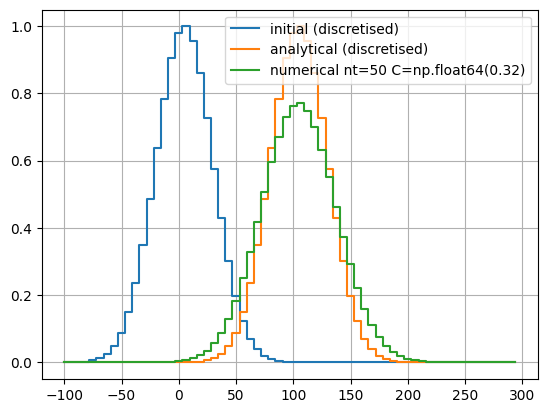

In [19]:
pyplot.step(x, psi_0(x), label='initial (discretised)', where='mid')
pyplot.step(x, psi_0(x-u*t_max), label='analytical (discretised)', where='mid')
pyplot.step(x, psi, label=f'numerical {nt=} {C=}', where='mid')
pyplot.legend()
pyplot.grid()

### RMSE calculation

In [20]:
def RMSE(nt):
  one = One()
  i = slice(1,nx-2)
  psi = psi_0(x)
  dt = t_max/nt
  C = u*dt/dx
  for _ in range(nt):
      psi[i] = psi[i] - (F(psi[i],psi[i+one],C) - F(psi[i-one],psi[i],C))
  psi_analytical = psi_0(x - u * t_max)
  return np.sqrt(np.mean((psi - psi_analytical)**2))


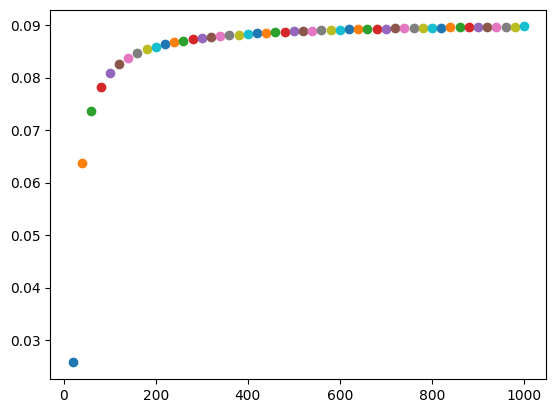

In [24]:
# Evaluate analytical solution at final time (discretized)
psi_analytical = psi_0(x - u * t_max)

# Compute RMSE between numerical and analytical
rmse = np.sqrt(np.mean((psi - psi_analytical)**2))
nt = np.linspace(20, 1000).astype(int)

for i in nt:
  rmse = RMSE(i)
  pyplot.plot(i, rmse, 'o', label='RMSE points')  # 'o' means circle markers


